# GPyTorch regression with derivative information

## Introduction
In this notebook, we show how to train a GP regression model in GPyTorch of an unknown function given function value and derivative observations. We consider modeling the function:

\begin{align*}
              y &= \sin(2x) + cos(x) + \epsilon \\
  \frac{dy}{dx} &= 2\cos(2x) - \sin(x) + \epsilon \\  
       \epsilon &\sim \mathcal{N}(0, 0.5)
\end{align*}

using 50 value and derivative observations.

In [1]:
import torch
import gpytorch
import math
from matplotlib import pyplot as plt
import numpy as np

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Setting up the training data
We use 50 uniformly distributed points in the interval $[0, 5 \pi]$

In [19]:
lb, ub = 0.0, 5*math.pi
n = 50

train_x = torch.linspace(lb, ub, n).unsqueeze(-1)
train_y = torch.stack([
    torch.sin(2*train_x) + torch.cos(train_x), 
    -torch.sin(train_x) + 2*torch.cos(2*train_x)
], -1).squeeze(1)

train_y += 0.05 * torch.randn(n, 2)

## Setting up the model
A GP prior on the function values implies a multi-output GP prior on the function values and the partial derivatives, see 9.4 in http://www.gaussianprocess.org/gpml/chapters/RW9.pdf for more details. This allows using a `MultitaskMultivariateNormal` and `MultitaskGaussianLikelihood` to train a GP model from both function values and gradients. The resulting RBF kernel that models the covariance between the values and partial derivatives has been implemented in `RBFKernelGrad` and the extension of a constant mean is implemented in `ConstantMeanGrad`.

The `RBFKernelGrad` is generally worse conditioned than the `RBFKernel`, so we place a lower bound on the noise parameter to keep the smallest eigenvalues of the kernel matrix away from zero.

In [22]:
class GPModelWithDerivatives(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModelWithDerivatives, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMeanGrad()
        self.base_kernel = gpytorch.kernels.PolynomialKernelGrad(power=2)
        self.covar_module = gpytorch.kernels.ScaleKernel(self.base_kernel)

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)  # Value + Derivative
model = GPModelWithDerivatives(train_x, train_y, likelihood)

## Training the model
The model training is similar to training a standard GP regression model

In [23]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

n_iter = 50
for i in range(n_iter):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   offset: %.3f   noise: %.3f' % (
        i + 1, n_iter, loss.item(),
        model.covar_module.base_kernel.offset.item(),
        model.likelihood.noise.item()
    ))        
    optimizer.step()

Iter 1/50 - Loss: 93.724   offset: 0.693   noise: 0.693
Iter 2/50 - Loss: 92.825   offset: 0.644   noise: 0.744
Iter 3/50 - Loss: 92.090   offset: 0.598   noise: 0.798
Iter 4/50 - Loss: 91.469   offset: 0.554   noise: 0.852
Iter 5/50 - Loss: 90.969   offset: 0.513   noise: 0.907
Iter 6/50 - Loss: 90.599   offset: 0.474   noise: 0.961
Iter 7/50 - Loss: 90.282   offset: 0.438   noise: 1.013
Iter 8/50 - Loss: 90.035   offset: 0.404   noise: 1.062
Iter 9/50 - Loss: 89.839   offset: 0.373   noise: 1.107
Iter 10/50 - Loss: 89.683   offset: 0.344   noise: 1.147
Iter 11/50 - Loss: 89.550   offset: 0.317   noise: 1.180
Iter 12/50 - Loss: 89.449   offset: 0.292   noise: 1.206
Iter 13/50 - Loss: 89.356   offset: 0.269   noise: 1.226
Iter 14/50 - Loss: 89.259   offset: 0.248   noise: 1.238
Iter 15/50 - Loss: 89.167   offset: 0.228   noise: 1.243
Iter 16/50 - Loss: 89.065   offset: 0.210   noise: 1.243
Iter 17/50 - Loss: 88.967   offset: 0.194   noise: 1.237
Iter 18/50 - Loss: 88.869   offset: 0.17

## Making predictions with the model
Model predictions are also similar to GP regression with only function values, butwe need more CG iterations to get accurate estimates of the predictive variance

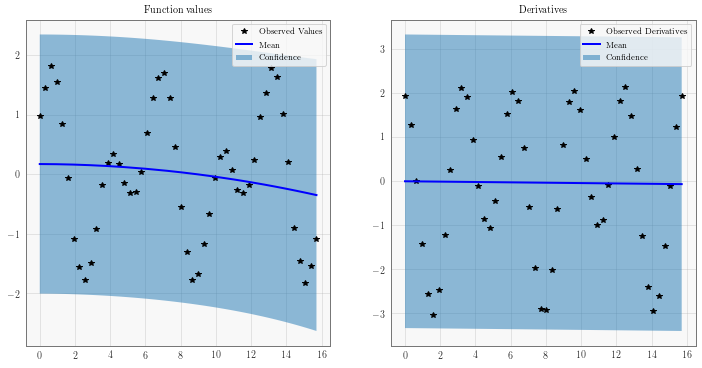

In [24]:
# Set into eval mode
model.train()
model.eval()
likelihood.eval()

# Initialize plots
f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(12, 6))

# Make predictions
with torch.no_grad(), gpytorch.settings.max_cg_iterations(50):
    test_x = torch.linspace(lb, ub, 500)
    predictions = likelihood(model(test_x))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()
    
# Plot training data as black stars
y1_ax.plot(train_x.detach().numpy(), train_y[:, 0].detach().numpy(), 'k*')
# Predictive mean as blue line
y1_ax.plot(test_x.numpy(), mean[:, 0].numpy(), 'b')
# Shade in confidence 
y1_ax.fill_between(test_x.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
y1_ax.legend(['Observed Values', 'Mean', 'Confidence'])
y1_ax.set_title('Function values')

# Plot training data as black stars
y2_ax.plot(train_x.detach().numpy(), train_y[:, 1].detach().numpy(), 'k*')
# Predictive mean as blue line
y2_ax.plot(test_x.numpy(), mean[:, 1].numpy(), 'b')
# Shade in confidence 
y2_ax.fill_between(test_x.numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.5)
y2_ax.legend(['Observed Derivatives', 'Mean', 'Confidence'])
y2_ax.set_title('Derivatives')

None